<a href="https://colab.research.google.com/github/Umed20/Twitter-Sentiment-Analysis/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('Sentiment.csv')
data.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,6.296972e+17,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,6.296972e+17,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,6.296972e+17,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,6.296972e+17,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,6.296972e+17,NaN,Arizona


In [4]:
# Keeping only necessary columns
data = data[['text','sentiment']]
data.head(2)

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive


In [5]:
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size=0.1)

In [6]:
# Removing nuetral sentiments
train = train[train.sentiment != "Nuetral"]

In [7]:
train.head(2)

,text,sentiment
185,IMHO #GOPDebate \nwinners #MarcoRubio #Kasich ...,Positive
1286,RT @shannonrwatts: Black males age 15 to 34 ar...,Negative


In [8]:
# Separating Negative and Positive tweets
train_pos = train[train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[train['sentiment'] == 'Negative']
train_neg = train_neg['text']

Positive Words


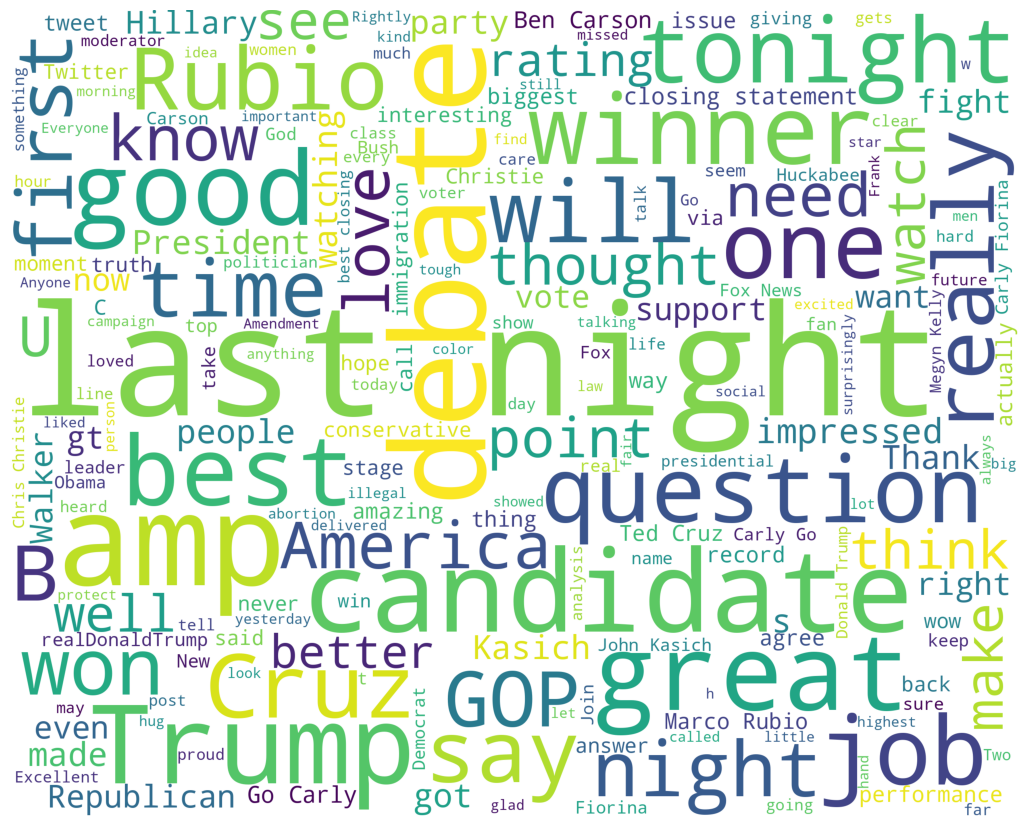

Negative words


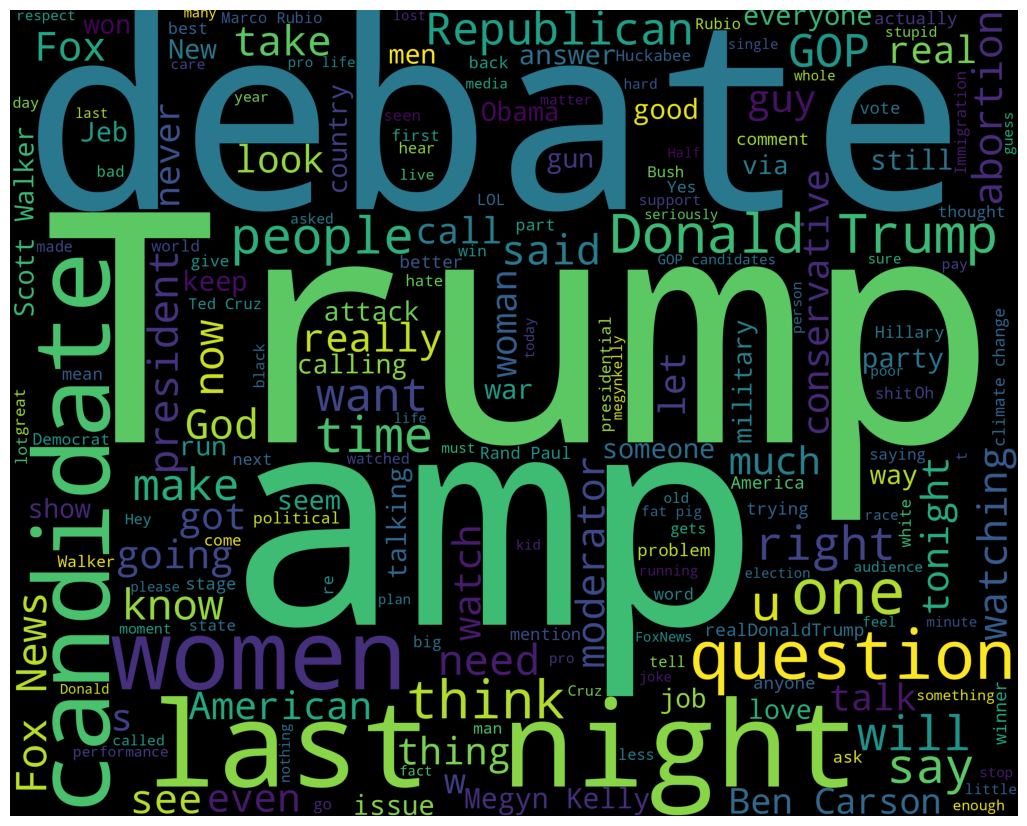

In [9]:
# Visualizing the words in positive and negative texts

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                             if 'http' not in word
                                 and not word.startswith('@')
                                 and not word.startswith('#')
                                 and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color=color, width=2500, height=2000).generate(cleaned_word)

    plt.figure(1,figsize=(13,13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive Words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [10]:
import nltk.data
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# Removing Stopwords
tweets = []
stopwords_set = set(stopwords.words('english'))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
                     if 'http' not in word
                     and not word.startswith('@')
                     and not word.startswith('#')
                     and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))

test_pos = test[test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[test['sentiment'] == 'Negative']
test_neg = test_neg['text']

In [13]:
# Extracting word features
def get_words_in_tweets(tweets):
  all = []
  for (words,sentiment) in tweets:
    all.extend(words)
  return all

def get_word_features(wordlist):
  wordlist = nltk.FreqDist(wordlist)
  features = wordlist.keys()
  return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
  document_words = set(document)
  features = {}
  for word in w_features:
    features['contains(%s)' % word] = (word in document_words)
  return features

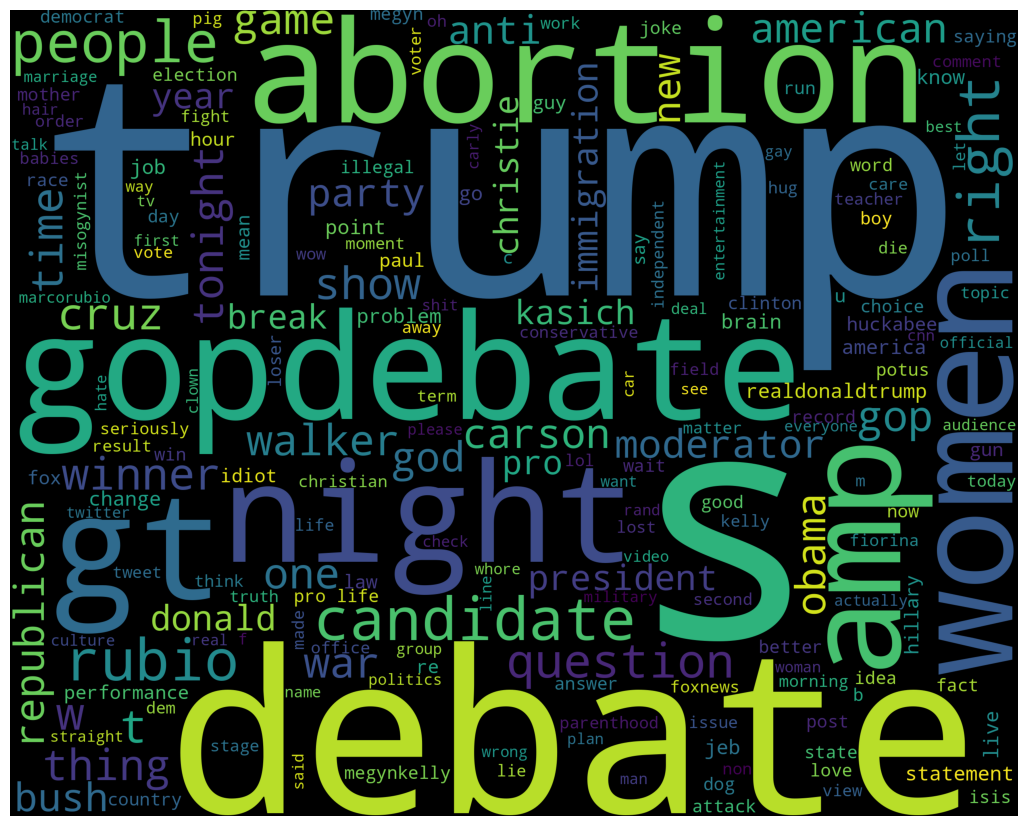

In [14]:
wordcloud_draw(w_features)

In [15]:
# Training the Naive Bayes Classifier
training_set = nltk.classify.apply_features(extract_features, tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [16]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg:
  res = classifier.classify(extract_features(obj.split()))
  if(res == 'Negative'):
    neg_cnt = neg_cnt + 1
for obj in test_pos:
  res = classifier.classify(extract_features(obj.split()))
  if(res == 'Positive'):
    pos_cnt = pos_cnt + 1

print('[Negative]: %s/%s' % (len(test_neg),neg_cnt))
print('[Positive]: %s/%s' % (len(test_pos),pos_cnt))

[Negative]: 214/198
[Positive]: 61/4


In [17]:
# Saving the model
import pickle

In [19]:
filename = 'trained_model.sav'
pickle.dump(classifier,open(filename,'wb'))

In [20]:
# Loading the saved model
loaded_model = pickle.load(open('/content/trained_model.sav','rb'))